In [1]:
import hdf5storage
import helpers as helpers
import get_data as get_data
import numpy as np
from get_data import *


%load_ext autoreload
%autoreload 2
lfp_mat = hdf5storage.loadmat('./bat/data/ephys/32622_231007_lfp.mat')
data_path = './data' # Replace this
bat_id = '32622'
date =  '231007'
session = FlightRoomSession(data_path, bat_id, date, use_cache = True) # use_cache = True to save time on future loads

Loading Flight Room | 32622 | 231007 from cache...


In [33]:
pos = session.cortex_data.bat_pos
cleaned_pos = np.copy(pos)
# still position on walls are nans (dont interpolate large gaps of nans)
cleaned_pos[:, 0] = interpolate_nans(pos[:, 0])
cleaned_pos[:, 1] = interpolate_nans(pos[:, 1])
cleaned_pos[:, 2] = interpolate_nans(pos[:, 2])
cleaned_pos.shape

(841160, 3)

In [34]:
from scipy.signal import decimate
lfp_timestamps = lfp_mat['global_sample_timestamps_usec'] #global timestamps in microseconds
lfp_timestamps_dec = decimate(lfp_timestamps.flatten(), 10) #decimate from 2500 Hz to 250 Hz

lfp_indices = lfp_timestamps_dec > 0 # lop off negative timestamps on LFP timestamps; we will use this to refit the LFP data later.

lfp_timestamps_dec = lfp_timestamps_dec[lfp_indices] 
lfp_timestamps_edges = np.insert(lfp_timestamps_dec, 0, 0) # insert 0 at the beginning

lfp_timestamps_edges.shape
#lfp_timestamps_edges[0:10]

(1706894,)

In [35]:
pos_timestamps = session.cortex_data.cortex_global_sample_timestamps_sec * 1e6 #converting to microseconds (usec)
valid_indices = pos_timestamps > 0 #we can use this to get rid of negative timestamps on anything position related

pos_timestamps = pos_timestamps[valid_indices] # lop off negative timestamps 
cleaned_pos = cleaned_pos[valid_indices] # lop off the corresponding positions

In [36]:
# Bin positional data using the provided label_timebins function
binned_pos_x = label_timebins(lfp_timestamps_edges, cleaned_pos[:, 0], pos_timestamps, is_discrete=False)
binned_pos_y = label_timebins(lfp_timestamps_edges, cleaned_pos[:, 1], pos_timestamps, is_discrete=False)
binned_pos_z = label_timebins(lfp_timestamps_edges, cleaned_pos[:, 2], pos_timestamps, is_discrete=False)

# Construct the array according to its columns
binned_pos = np.column_stack((binned_pos_x, binned_pos_y, binned_pos_z))

In [37]:
from rat.get_data import get_LFP_from_mat
lfp_data_1 = lfp_mat['lfp'][0, 0]
lfp_data_2 = lfp_mat['lfp'][0, 1]
n_channels = lfp_data_1.shape[0] #same # of channels for lfp_data_1 and lfp_data_2 (change if not the case)
# bat LFP data sampled at 2500 Hz
lfp_bat_1 = get_LFP_from_mat(lfp_data_1,n_channels,2500,fs=250, use_cache=True) 
lfp_bat_2 = get_LFP_from_mat(lfp_data_2,n_channels,2500,fs=250, use_cache=True)
test_LFP = np.concatenate((lfp_bat_1, lfp_bat_2), axis=1)

In [38]:
test_LFP = test_LFP[lfp_indices]
test_LFP.shape

#lfp_timestamps_edges.shape

(1706893, 384)

In [39]:
from bat.get_data import get_flightLFP

tLFP = get_flightLFP(session, test_LFP, valid_indices, lfp_timestamps_edges, pos_timestamps,off_samples=250)

Shape of LFPs: (1706893, 384)
Length of valid_indices: 841160
Length of lfp_timestamps_decimated_bins: 1706894
Length of pos_timestamps: 824435
Cluster 2: 34 flights

Processing flight 1
Length of flight_bool: 841160
Sum of flight_bool: 987
Length of labels after valid_indices: 824435
Sum of labels: 987
Length of timebin_labels: 1706893
Sum of timebin_labels: 987.0
Shape of flight_lfp: (987, 384)
Shape of flight_phases: (987,)
Added flight data with shape: (987, 386)
Unique phase labels: [0. 1. 2.]

Processing flight 2
Length of flight_bool: 841160
Sum of flight_bool: 976
Length of labels after valid_indices: 824435
Sum of labels: 976
Length of timebin_labels: 1706893
Sum of timebin_labels: 976.0
Shape of flight_lfp: (976, 384)
Shape of flight_phases: (976,)
Added flight data with shape: (976, 386)
Unique phase labels: [0. 1. 2.]

Processing flight 3
Length of flight_bool: 841160
Sum of flight_bool: 985
Length of labels after valid_indices: 824435
Sum of labels: 985
Length of timebin_l

In [40]:
first_column_tLFP = tLFP[:, 4]
print(first_column_tLFP)

[ 1280.   896.   704. ...  -768. -1536. -1472.]


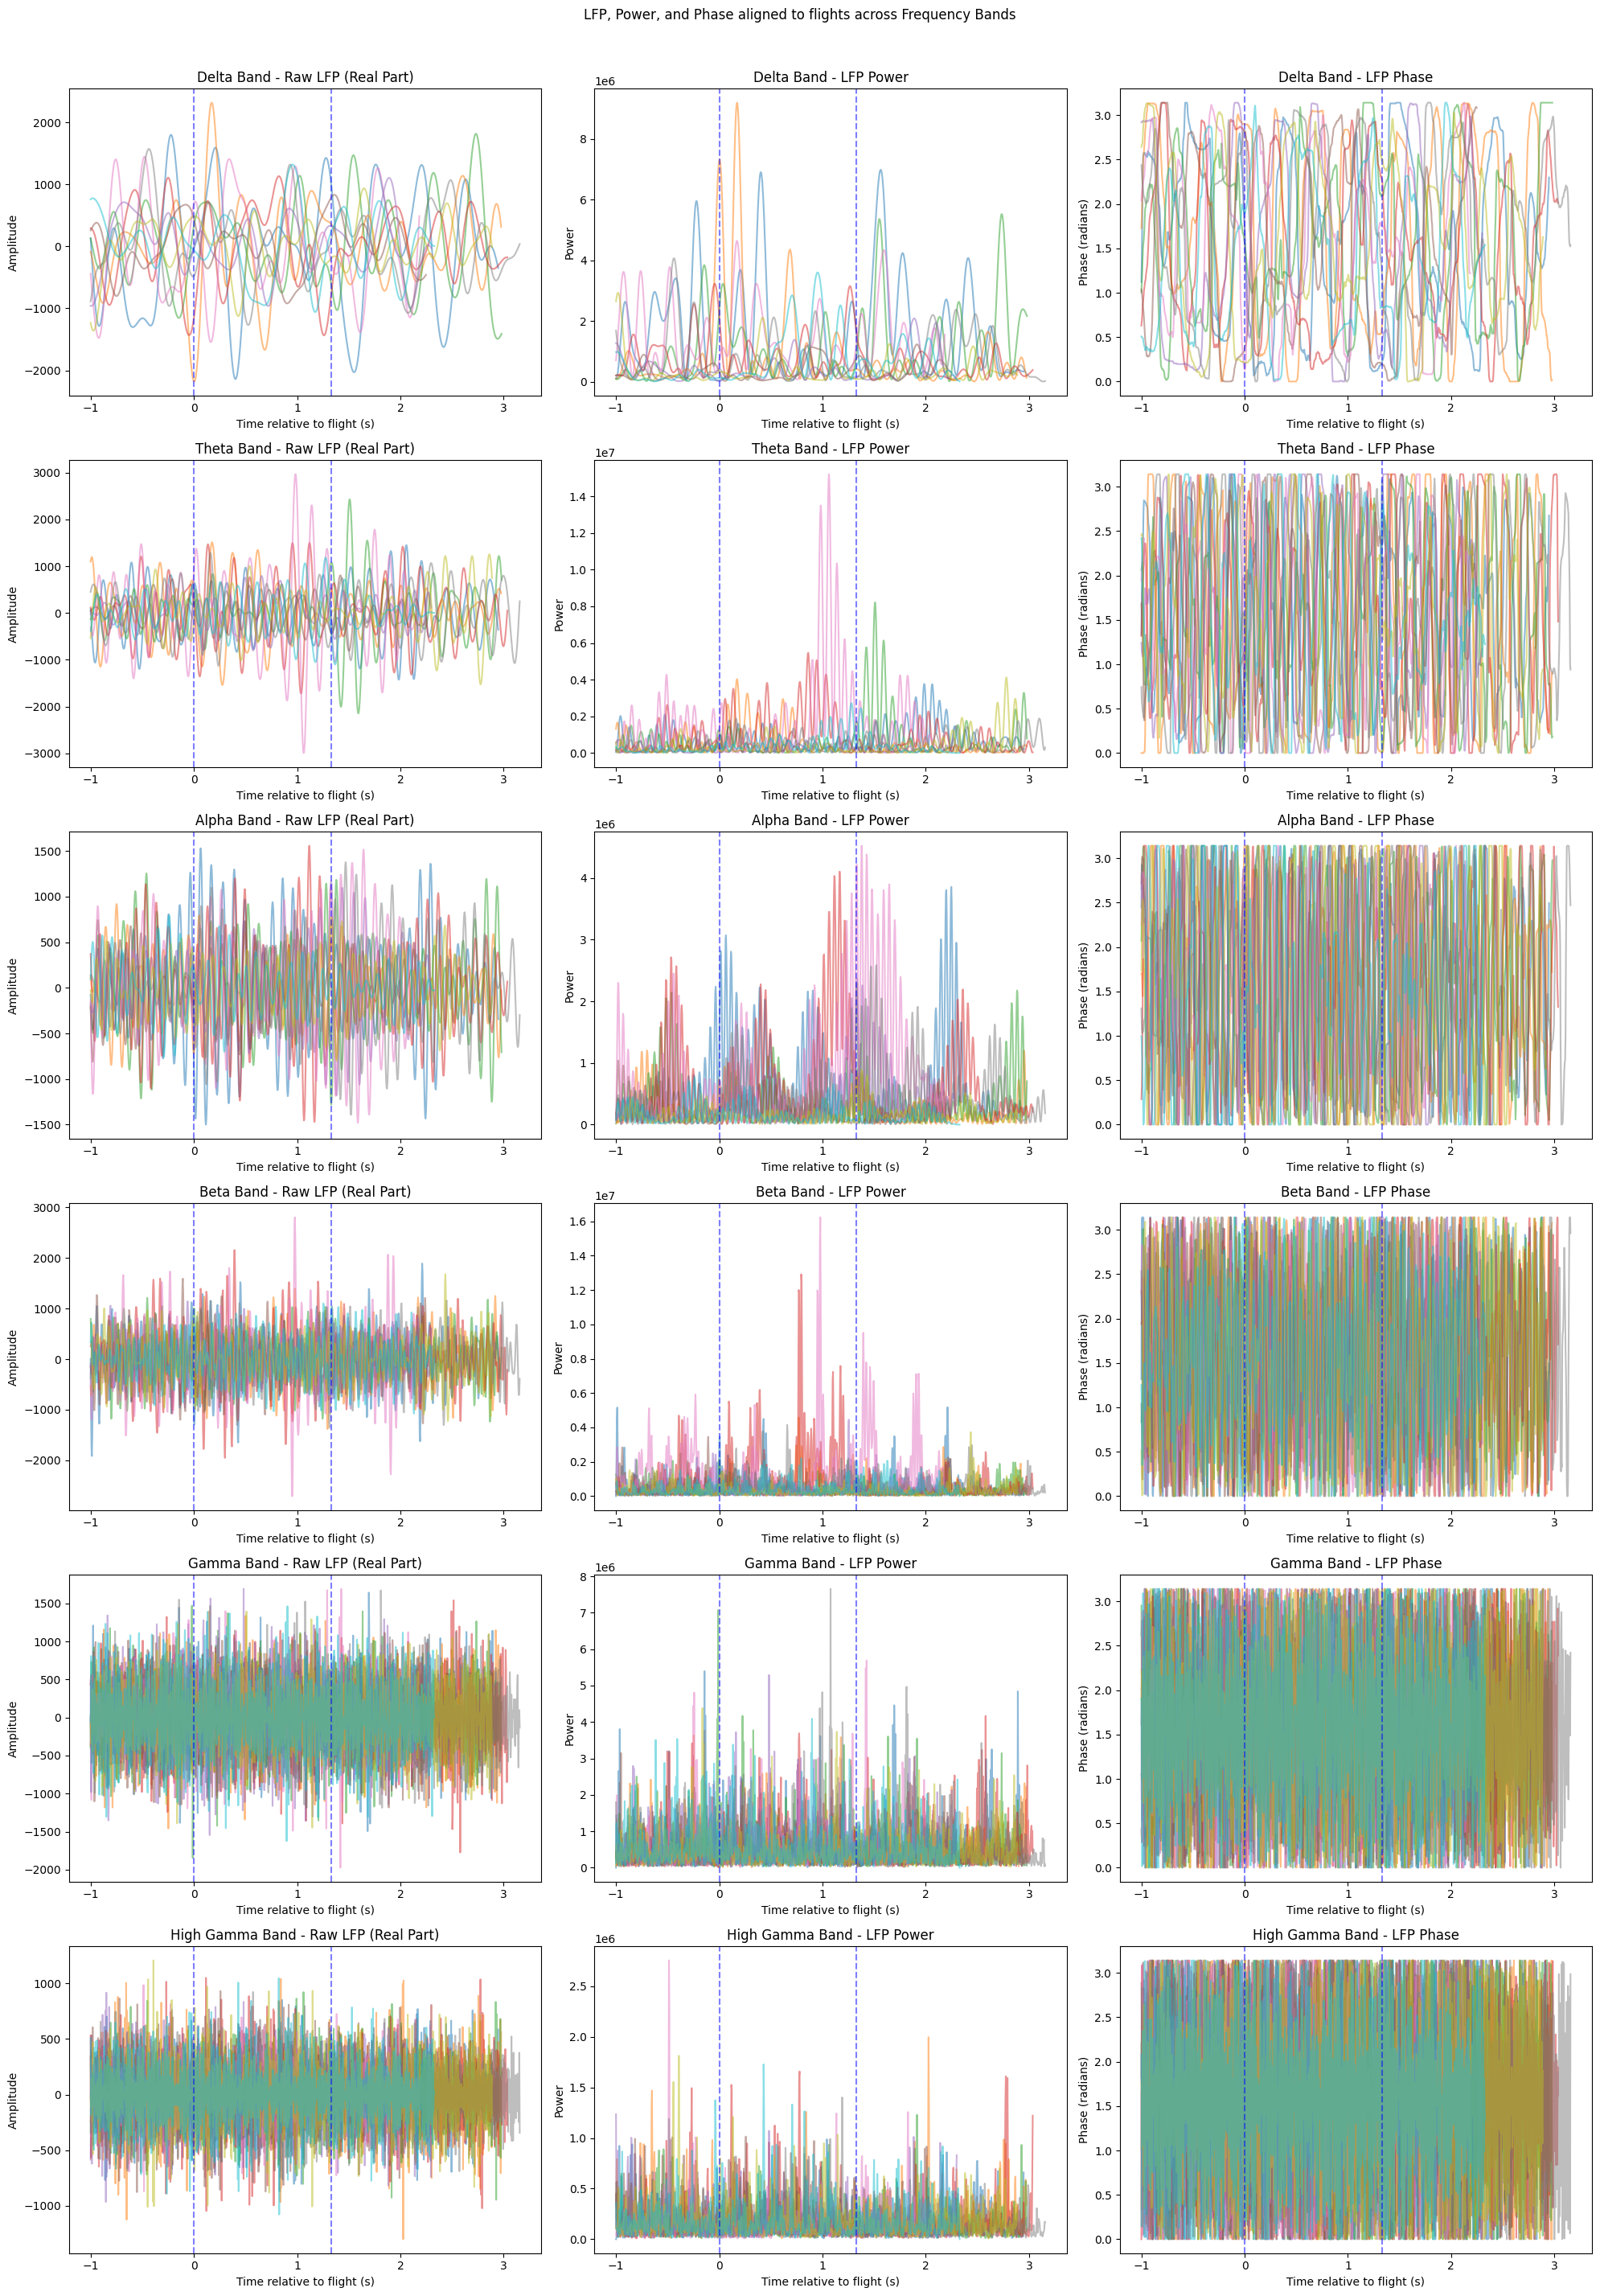

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    low = min(low, 0.99)  # Ensure frequencies are below Nyquist
    high = min(high, 0.99)
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data, axis=0)

def plot_lfp_alignment_by_band(flightLFP, sampling_rate=250, n_flights_to_plot=10, off_samples=250):
    num_flights = int(np.max(flightLFP[:, 0]))
    flights_to_plot = np.linspace(0, num_flights-1, n_flights_to_plot, dtype=int)
    
    frequency_bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 80),
        'High Gamma': (80, 120)  # Adjusted to be below Nyquist frequency
    }
    
    fig, axes = plt.subplots(len(frequency_bands), 3, figsize=(20, 5 * len(frequency_bands)))
    
    for band_idx, (band_name, (lowcut, highcut)) in enumerate(frequency_bands.items()):
        # Filter LFP data for the current band
        filtered_data = bandpass_filter(flightLFP[:, 2:], lowcut, highcut, sampling_rate)
        
        for flight_idx in flights_to_plot:
            flight_mask = flightLFP[:, 0] == flight_idx+1
            flight_data = filtered_data[flight_mask]
            flight_phases = flightLFP[flight_mask, 1]
            
            if len(flight_data) == 0:
                continue
            
            # Calculate time bins
            total_samples = len(flight_data)
            flight_samples = np.sum(flight_phases == 1)
            time_bins = np.linspace(-off_samples/sampling_rate, (total_samples-off_samples)/sampling_rate, total_samples)
            
            # Plot raw LFP (mean across channels, real part)
            axes[band_idx, 0].plot(time_bins, np.mean(np.real(flight_data), axis=1), alpha=0.5, label=f'Flight {flight_idx+1}')
            
            # Calculate and plot power
            power = np.abs(flight_data)**2
            axes[band_idx, 1].plot(time_bins, np.mean(power, axis=1), alpha=0.5, label=f'Flight {flight_idx+1}')
            
            # Calculate and plot phase
            phase = np.angle(flight_data)
            axes[band_idx, 2].plot(time_bins, np.mean(phase, axis=1), alpha=0.5, label=f'Flight {flight_idx+1}')
        
        # Add vertical lines to separate pre-flight, in-flight, and post-flight phases
        for ax in axes[band_idx]:
            ax.axvline(x=0, color='b', linestyle='--', alpha=0.5)
            ax.axvline(x=flight_samples/sampling_rate, color='b', linestyle='--', alpha=0.5)
        
        axes[band_idx, 0].set_title(f'{band_name} Band - Raw LFP (Real Part)')
        axes[band_idx, 0].set_xlabel('Time relative to flight (s)')
        axes[band_idx, 0].set_ylabel('Amplitude')
        
        axes[band_idx, 1].set_title(f'{band_name} Band - LFP Power')
        axes[band_idx, 1].set_xlabel('Time relative to flight (s)')
        axes[band_idx, 1].set_ylabel('Power')
        
        axes[band_idx, 2].set_title(f'{band_name} Band - LFP Phase')
        axes[band_idx, 2].set_xlabel('Time relative to flight (s)')
        axes[band_idx, 2].set_ylabel('Phase (radians)')
    
    plt.suptitle('LFP, Power, and Phase aligned to flights across Frequency Bands')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Example usage:
plot_lfp_alignment_by_band(tLFP, sampling_rate=250, n_flights_to_plot=10, off_samples=250)

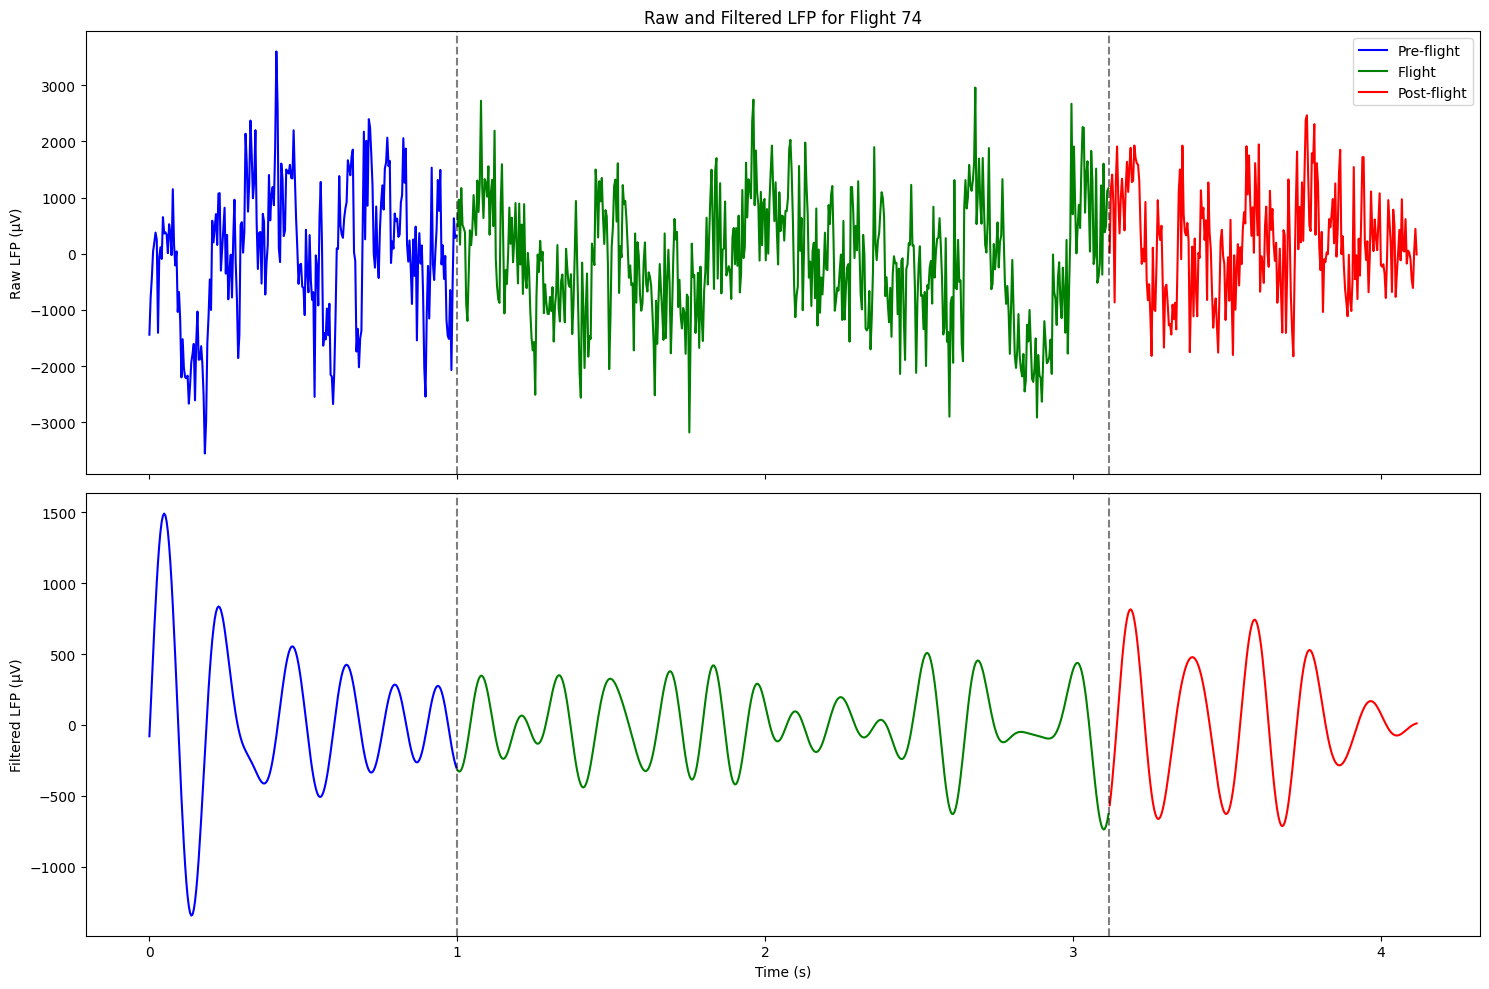

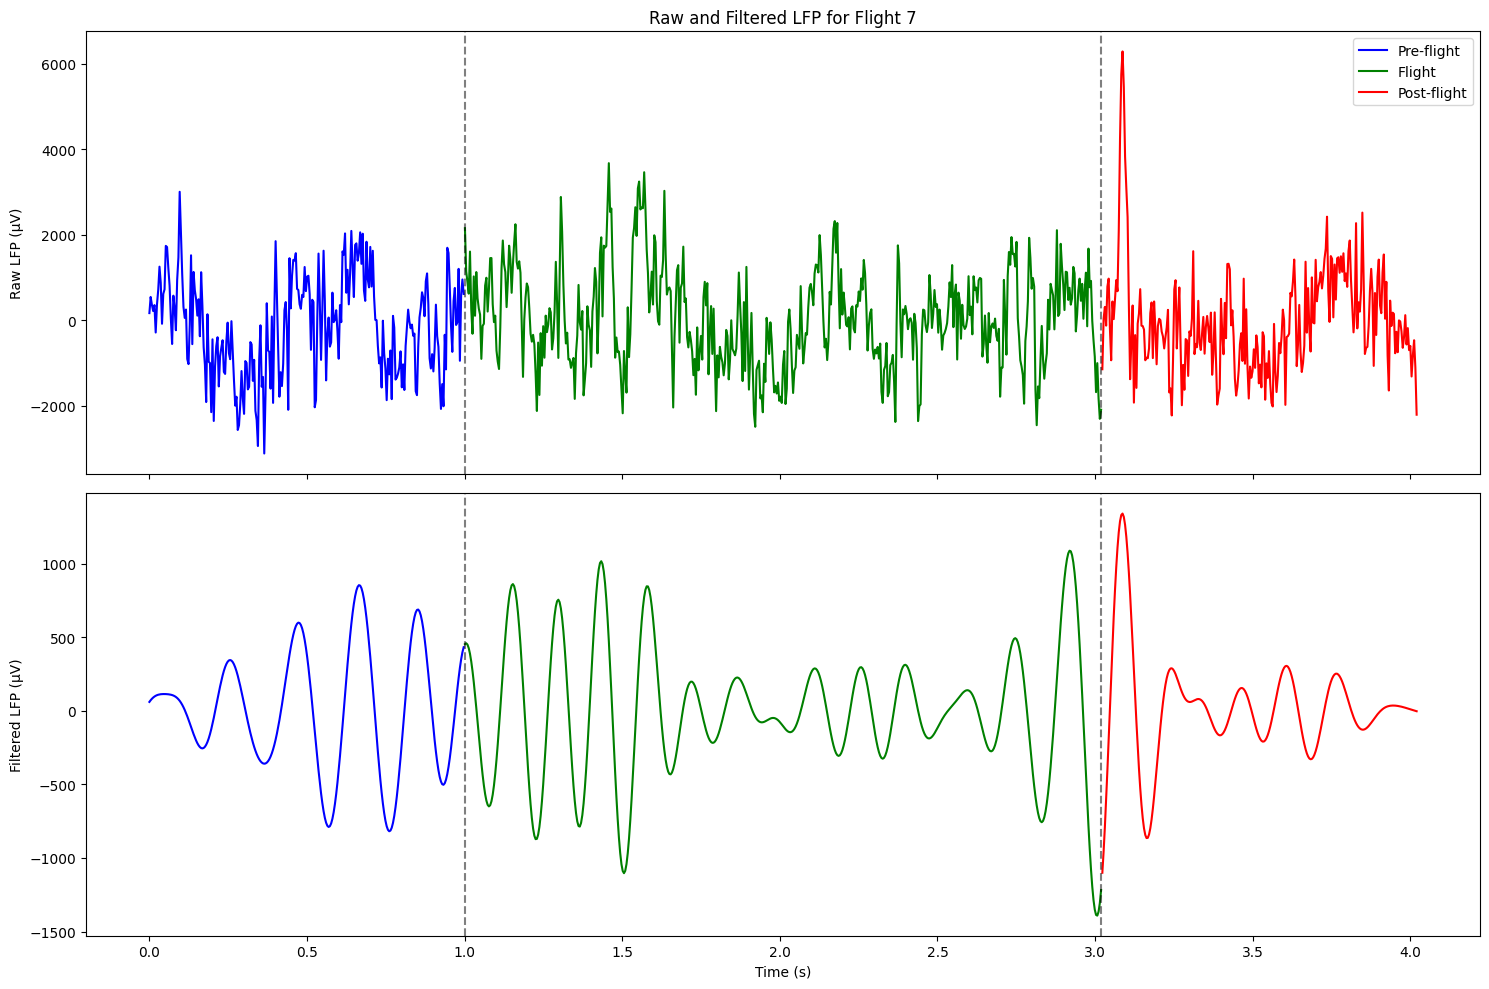

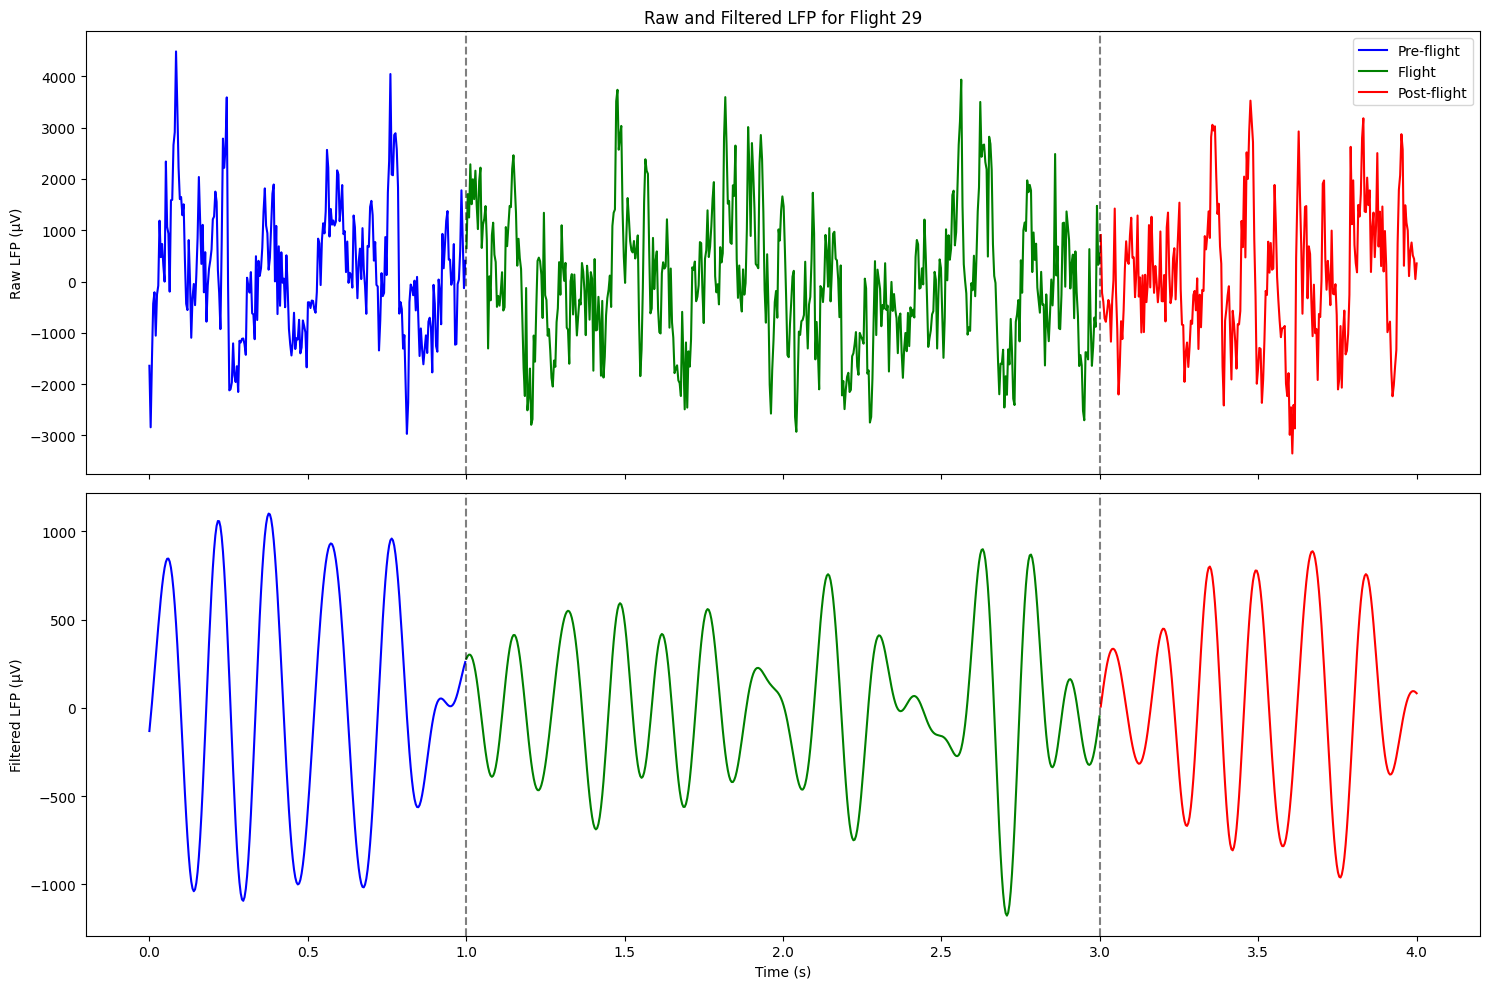

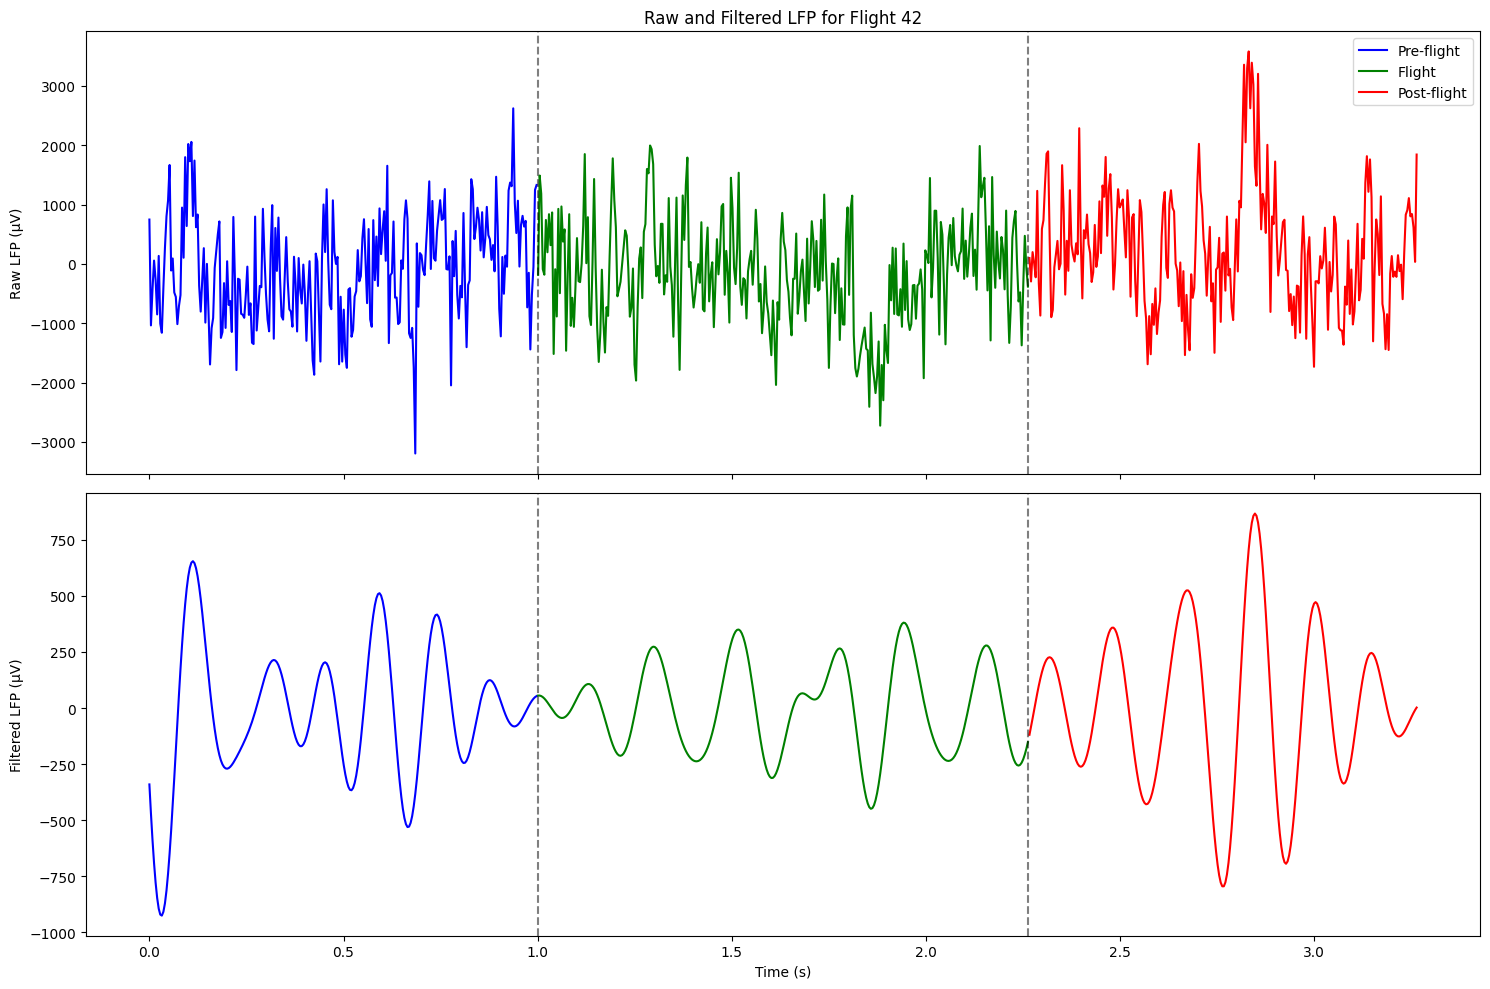

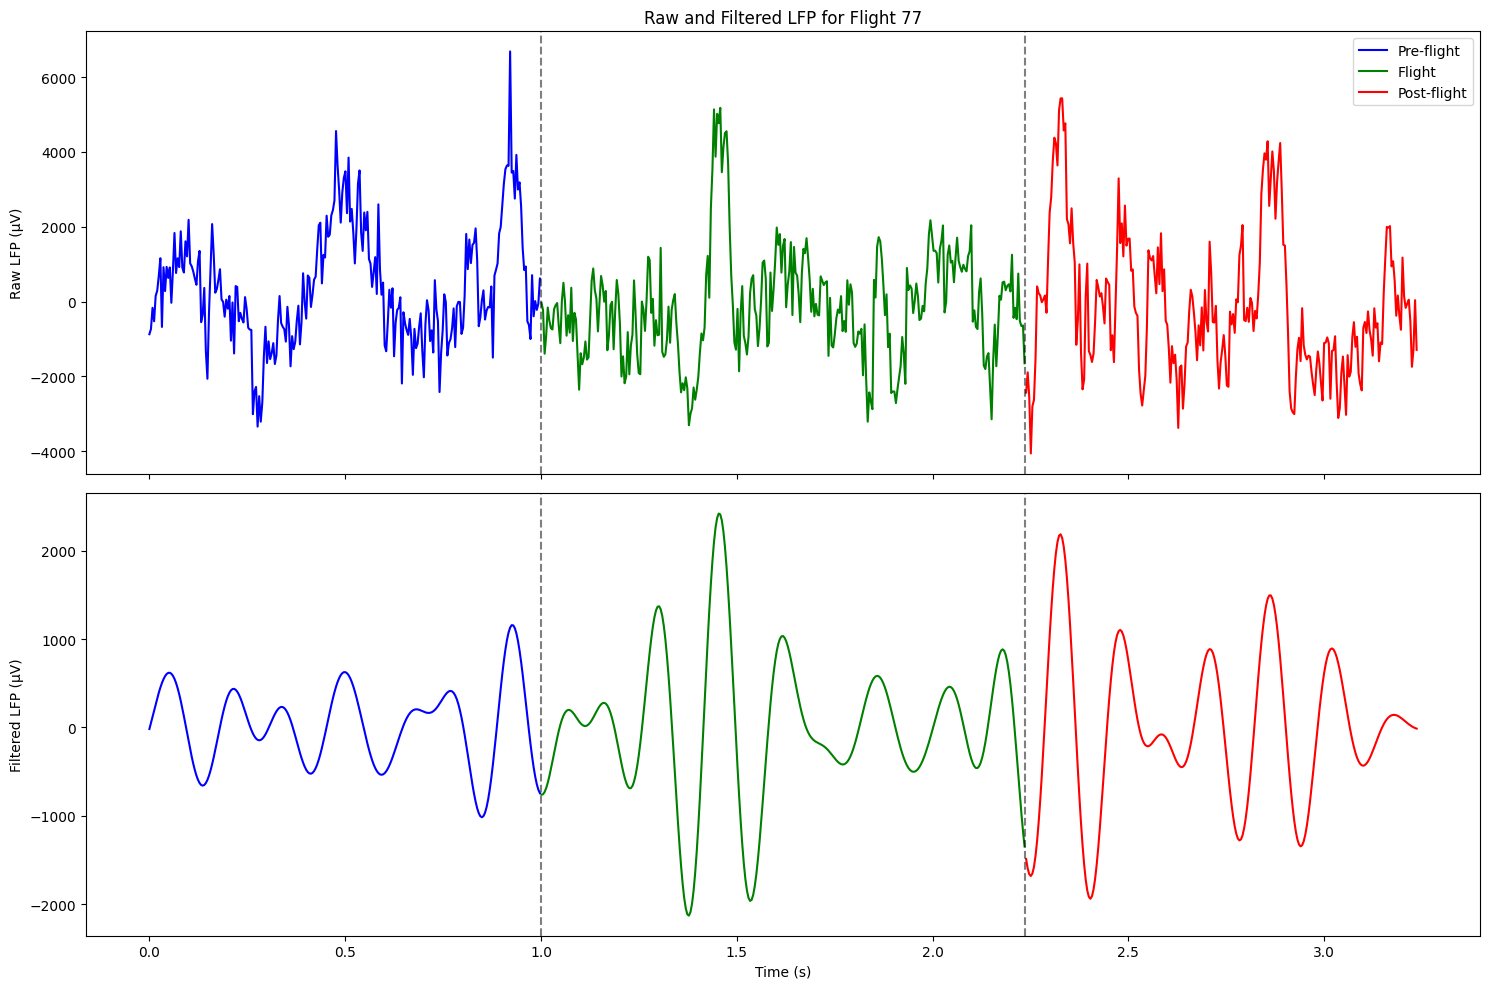

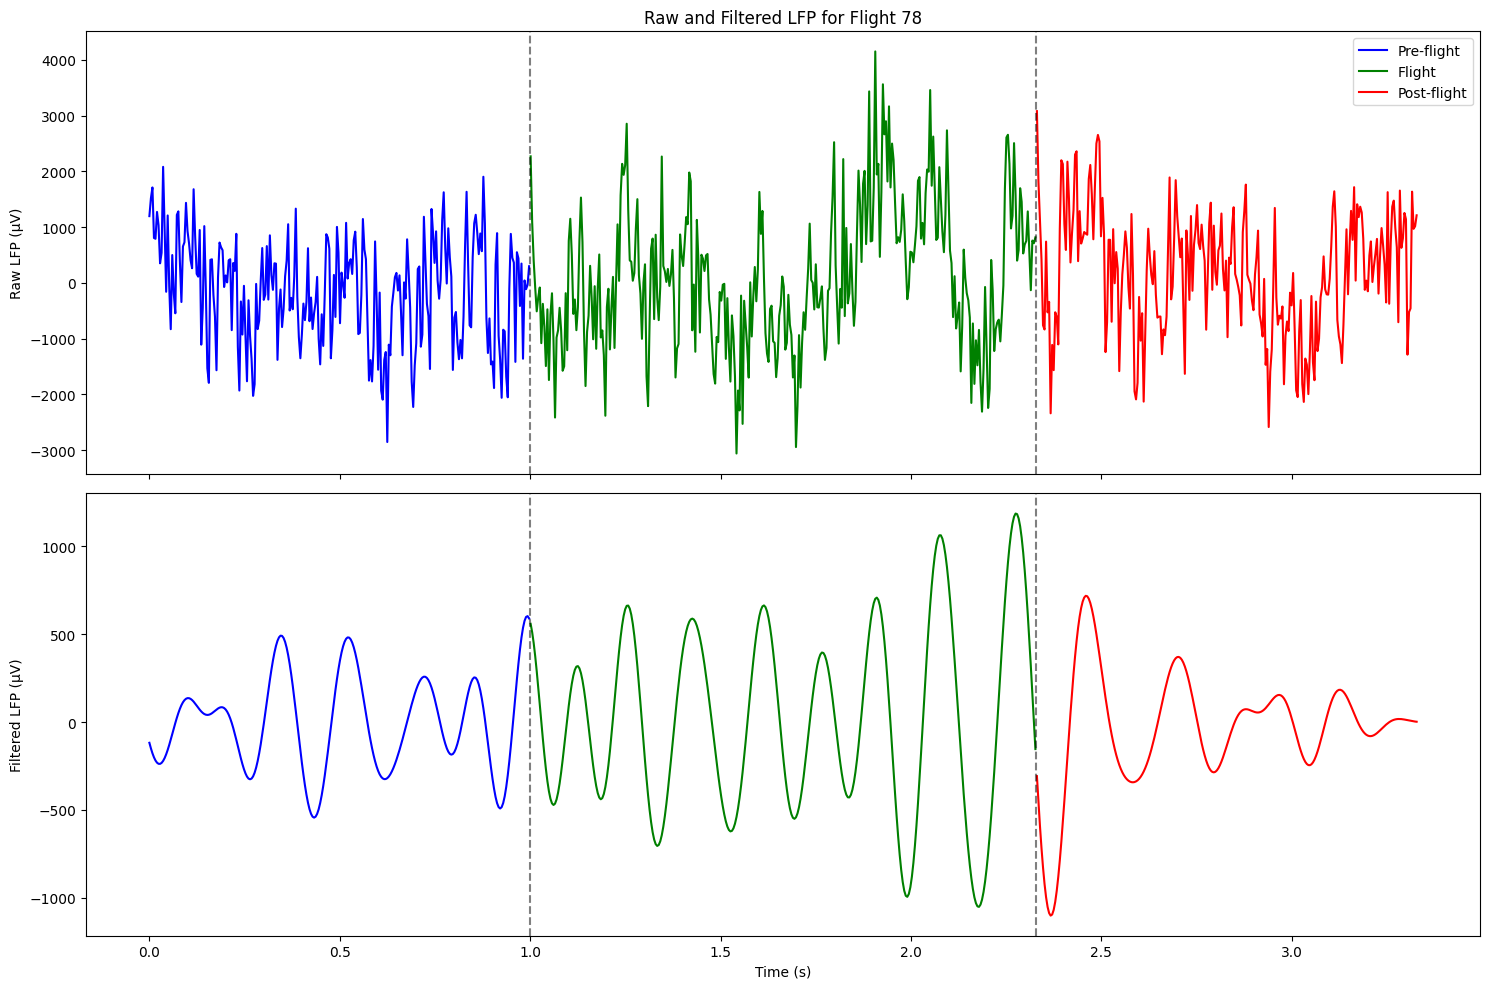

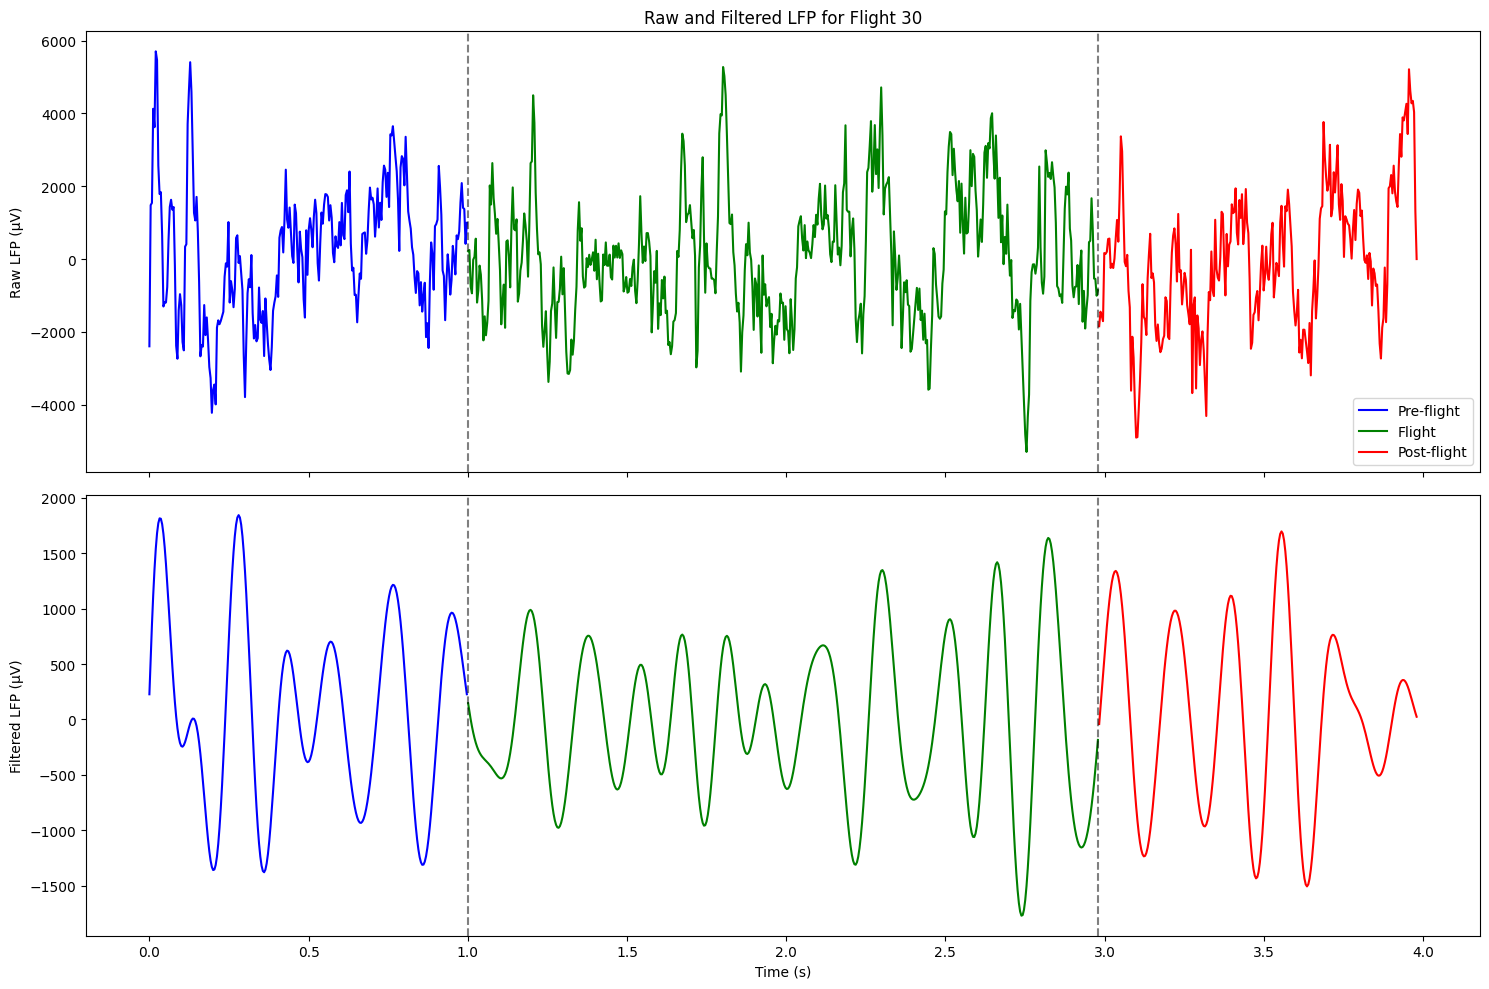

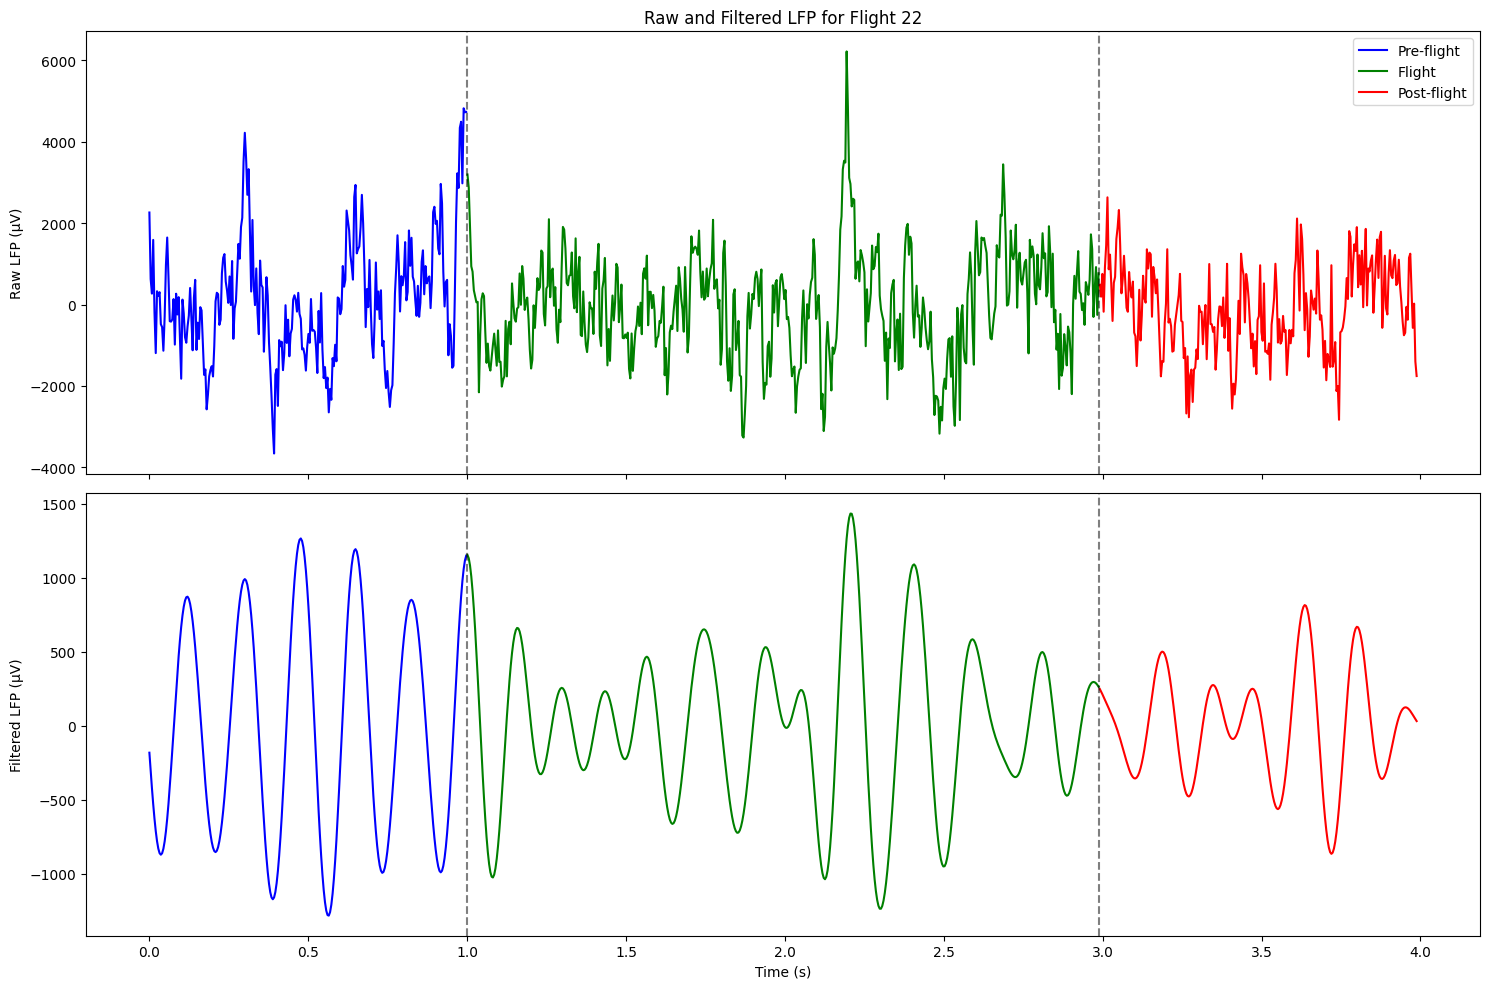

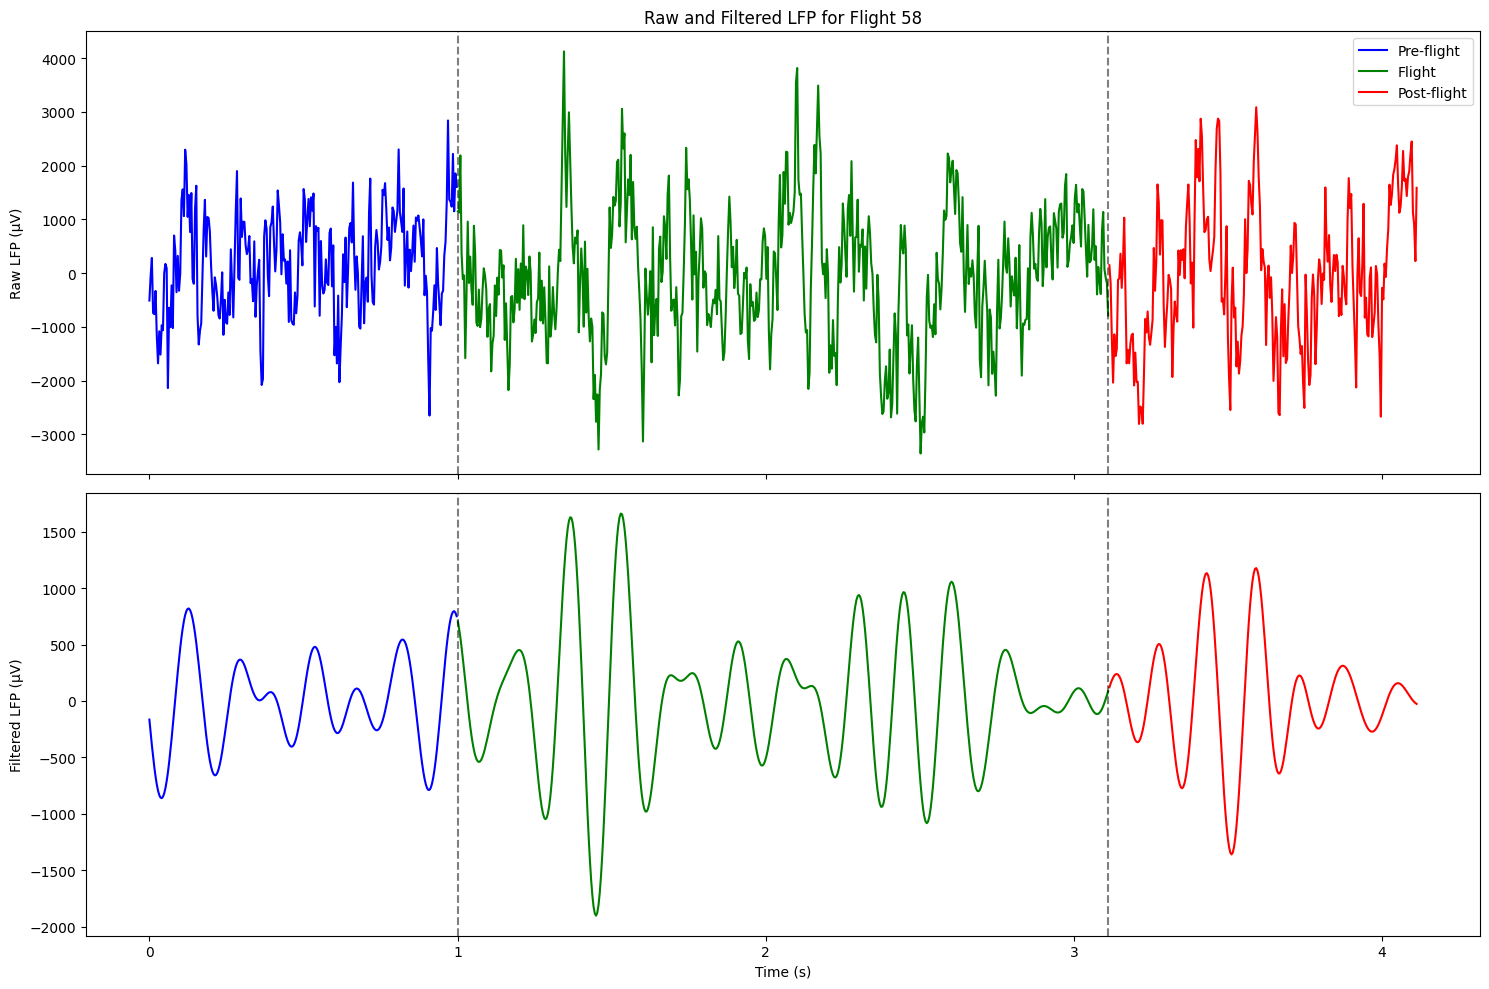

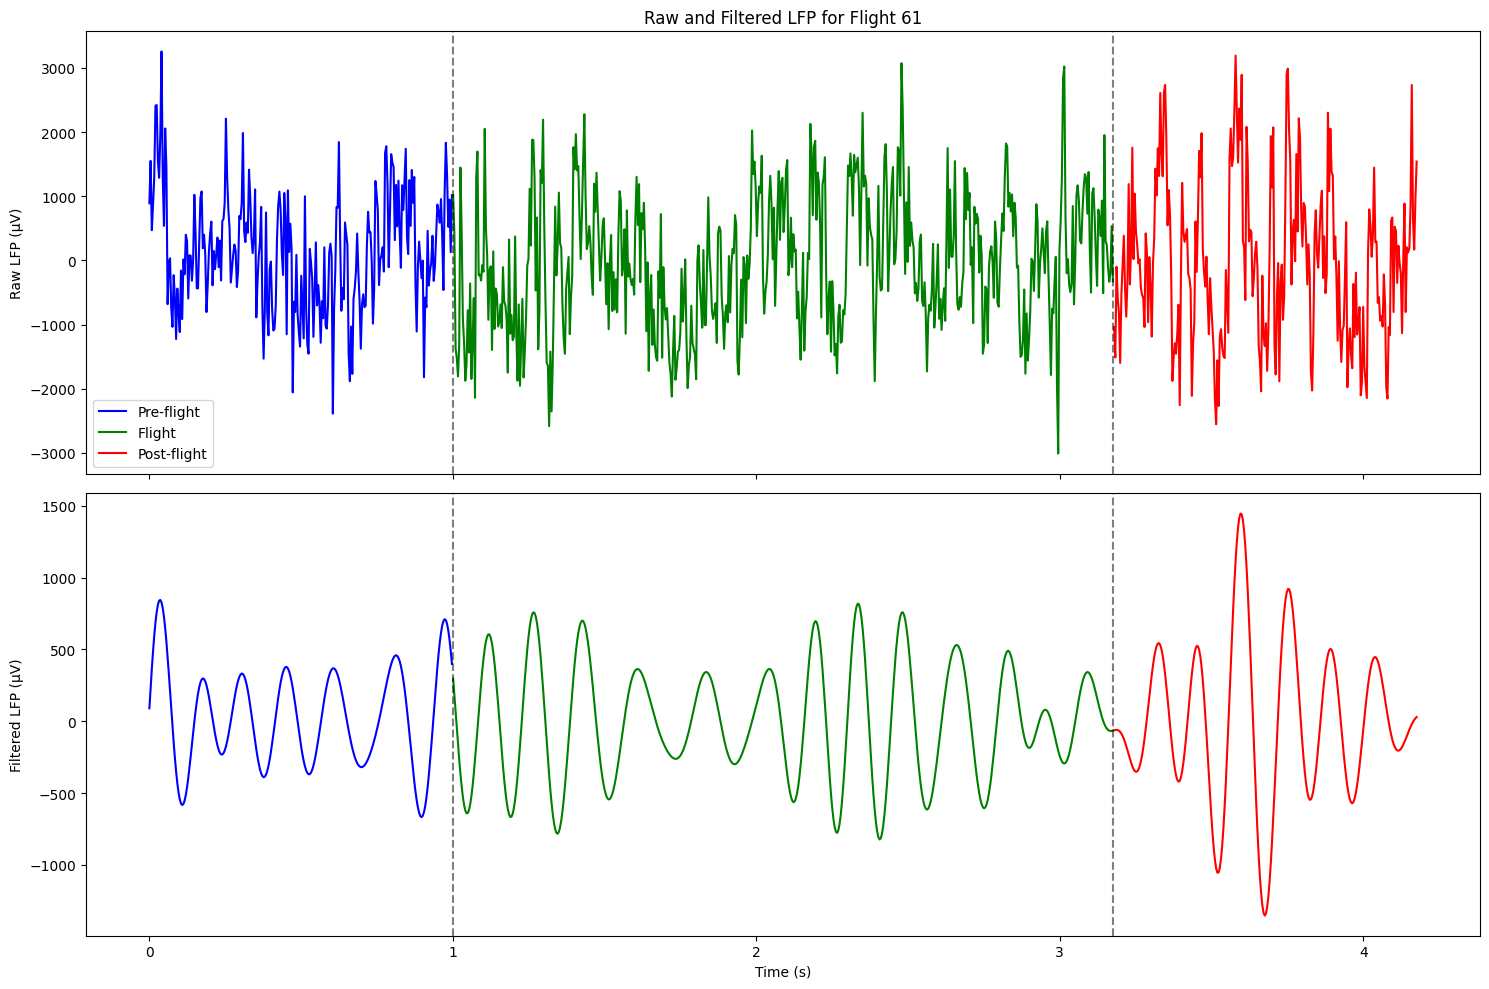

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    low = min(low, 0.99)
    high = min(high, 0.99)
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data, axis=0)

def plot_lfp_alignment(flightLFP, sampling_rate=250, n_flights_to_plot=1, off_samples=1250):
    num_flights = int(np.max(flightLFP[:, 0]))
    flights_to_plot = np.random.choice(num_flights, n_flights_to_plot, replace=False)
    
    for flight_idx in flights_to_plot:
        flight_mask = flightLFP[:, 0] == flight_idx+1
        flight_data = flightLFP[flight_mask, 2:]  # LFP data
        flight_phases = flightLFP[flight_mask, 1]
        
        if len(flight_data) == 0:
            continue
        
        # Calculate time bins
        total_samples = len(flight_data)
        time_bins = np.linspace(0, total_samples/sampling_rate, total_samples)
        
        # Separate pre-flight, flight, and post-flight data
        pre_flight_mask = flight_phases == 0
        flight_mask = flight_phases == 1
        post_flight_mask = flight_phases == 2
        
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
        
        # Plot raw LFP
        ax1.plot(time_bins[pre_flight_mask], np.mean(flight_data[pre_flight_mask], axis=1), color='blue', label='Pre-flight')
        ax1.plot(time_bins[flight_mask], np.mean(flight_data[flight_mask], axis=1), color='green', label='Flight')
        ax1.plot(time_bins[post_flight_mask], np.mean(flight_data[post_flight_mask], axis=1), color='red', label='Post-flight')
        ax1.set_ylabel('Raw LFP (µV)')
        ax1.legend()
        ax1.set_title(f'Raw and Filtered LFP for Flight {flight_idx+1}')
        
        # Filter LFP data (e.g., theta band: 4-8 Hz)
        filtered_data = bandpass_filter(flight_data, 4, 8, sampling_rate)
        
        # Plot filtered LFP
        ax2.plot(time_bins[pre_flight_mask], np.mean(filtered_data[pre_flight_mask], axis=1), color='blue')
        ax2.plot(time_bins[flight_mask], np.mean(filtered_data[flight_mask], axis=1), color='green')
        ax2.plot(time_bins[post_flight_mask], np.mean(filtered_data[post_flight_mask], axis=1), color='red')
        ax2.set_ylabel('Filtered LFP (µV)')
        ax2.set_xlabel('Time (s)')
        
        # Add vertical lines to separate flight phases
        for ax in [ax1, ax2]:
            ax.axvline(x=np.sum(pre_flight_mask)/sampling_rate, color='k', linestyle='--', alpha=0.5)
            ax.axvline(x=(np.sum(pre_flight_mask) + np.sum(flight_mask))/sampling_rate, color='k', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()

# Example usage:
plot_lfp_alignment(tLFP, sampling_rate=250, n_flights_to_plot=10, off_samples=250)